<a href="https://colab.research.google.com/github/hoomanabasi/BERT-Sentiment-Analysis/blob/main/BERT_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import swifter
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import nltk
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.data.path.append('/root/nltk_data/')

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"
,encoding='latin-1'
,names=['label', 'id', 'date', 'QUERY','name','text'])
df = df.sample(n=2000, random_state=42)  # random_state برای تکرارپذیری
df['label'] = df['label'].map({0: 0, 2: 1, 4: 2})
df

,label,id,date,QUERY,name,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
...,...,...,...,...,...,...
778681,0,2322745231,Wed Jun 24 23:11:16 PDT 2009,NO_QUERY,Grinstead,To all those on their way to @media2009 have a...
801164,2,1468036408,Mon Apr 06 23:22:42 PDT 2009,NO_QUERY,JoannDEvans,I just made the most amazing Banana Bread
1088585,2,1969614016,Sat May 30 00:36:54 PDT 2009,NO_QUERY,ayanchakraborty,@shefaly Morning shefaly..the sun's always bli...
1295828,2,2003830093,Tue Jun 02 07:13:10 PDT 2009,NO_QUERY,Liamh22,I Would Like 20 More Followers By The End Of T...


In [ ]:
texts=df["text"]


def clean_english_text(
    text: str,
    remove_usernames: bool = True,
    remove_links: bool = True,
    remove_special_chars: bool = True,
    handle_emojis: str = "remove",  # "remove", "convert", "keep"
    remove_stopwords: bool = True,   # حذف استاپ‌وردها (مثل is, the, and)
    lemmatize: bool = True,         # تبدیل کلمات به ریشه (مثل running → run)
    remove_numbers: bool = False,
) -> str:
    """
    پردازش متن انگلیسی با قابلیت استفاده در پانداس.
    """
    # 1. حذف یوزرنیم‌ها
    if remove_usernames:
        text = re.sub(r'@\w+', '', text)
    # 2. حذف لینک‌ها
    if remove_links:
        text = re.sub(r'http\S+|www\.\S+', '', text)
    # 3. پردازش ایموجی‌ها
    if handle_emojis == "remove":
        text = emoji.replace_emoji(text, replace='')
    elif handle_emojis == "convert":
        text = emoji.demojize(text)
    # 4. حذف کاراکترهای ویژه و اعداد
    if remove_special_chars:
        text = re.sub(r'[^\w\s]', ' ', text)
    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    # 5. توکن‌سازی و حذف استاپ‌وردها
    tokens = word_tokenize(text.lower())
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    # 6. لماتیزاسیون (تبدیل به ریشه)
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


import swifter
df['cleaned_text'] = texts.swifter.apply(
    lambda x: clean_english_text(
        x,
        handle_emojis="convert",
        remove_stopwords=True,
        lemmatize=True
    )
)

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['label'],
    test_size=0.2,
    random_state=42
)
tokenizer= AutoTokenizer.from_pretrained("bert-base-uncased")
x_test_tokeized=tokenizer(X_test.tolist(),padding="max_length",max_length=128,truncation=True)
x_train_tokeized=tokenizer(X_train.tolist(),padding="max_length",max_length=128,truncation=True)

In [12]:
train_tf=tf.data.Dataset.from_tensor_slices((dict(x_train_tokeized),y_train.tolist()))
test_tf=tf.data.Dataset.from_tensor_slices((dict(x_test_tokeized),y_test.tolist()))
model=TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
hist=model.fit(train_tf.shuffle(100).batch(16),epochs=2,validation_data=test_tf.shuffle(100).batch(16),batch_size=16)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
100/100 [==============================] - 2705s 27s/step - loss: 0.6636 - accuracy: 0.6281 - val_loss: 0.5583 - val_accuracy: 0.7200
Epoch 2/2
100/100 [==============================] - 2652s 27s/step - loss: 0.4584 - accuracy: 0.7975 - val_loss: 0.5628 - val_accuracy: 0.7200


In [13]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_tf.batch(16)).logits
y_pred = tf.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

25/25 [==============================] - 232s 8s/step
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       195
           2       0.73      0.72      0.72       205

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



In [24]:
model.save_pretrained("/content/drive/MyDrive/savemodel/model")
tokenizer.save_pretrained("/content/drive/MyDrive/savemodel/tokenizer")


('/content/drive/MyDrive/savemodel/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/savemodel/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/savemodel/tokenizer/vocab.txt',
 '/content/drive/MyDrive/savemodel/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/savemodel/tokenizer/tokenizer.json')

In [20]:
from transformers import pipeline

sentiment_analyzer = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    framework="tf"
)

print(sentiment_analyzer("I love you"))
print(sentiment_analyzer("I hate this product!"))
print(sentiment_analyzer("The service was okay, but not great."))

Device set to use 0


[{'label': 'LABEL_0', 'score': 0.8616543412208557}]
[{'label': 'LABEL_0', 'score': 0.89748215675354}]
[{'label': 'LABEL_0', 'score': 0.588623046875}]


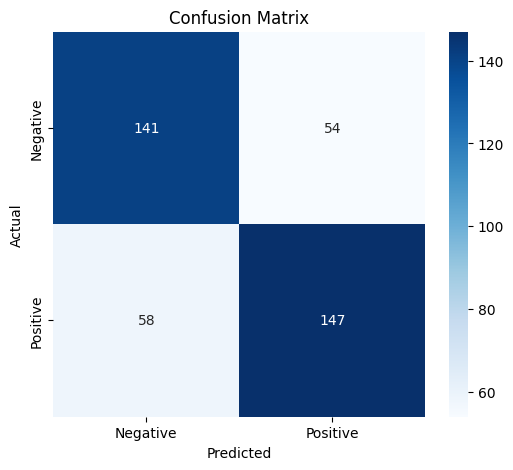

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative',  'Positive'], yticklabels=['Negative',  'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
